### Fill out:
Name & Surname: Zhen Xue, Gue

Student ID: 33521352

## W7&W8 post studio exercises (multivariate linear regression, regularisation)

Enter your solution in the cell(s) below each exercise. Add couple of inline comments explaining your code. Don't forget to add comments in markdown cell after each exercise. Missing comments (in markdown cells and/or inline) and late submissions will incur penalties.

Once done, drag&drop your python file to your ADS1002-name github account.

Copy url of this file on github to appropriate folder on Moodle by 09.30am prior your next studio. 

Solutions will be released later in the semester.

Max 10 marks - 2.5 marks per each exercise.

We will use diabetes data. Download this data from [the Gitlab site](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Machine-Learning/Supervised-Methods/Regression/Diabetes_Data.csv) into the same directory as the notebook on your computer. 

Run the following code from the pre-studio notebook.

In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression # models we are going to use
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # for comparing the predicted and test values
import seaborn as sns

In [52]:
df = pd.read_csv('Diabetes_Data.csv', usecols = range(0,11)) # read the Diabetes dataset in to a pandas dataframe
corrs = df.corr()          # calculate the correlation table
X = df.drop(['Y'],axis=1)  # Create a Dataframe without the target variable Y.
Y = df['Y']                # Extract a Series of the target Y values.

In [53]:
# The below code is identical to our first attempt, the only change is
# substituting nX for X in train_test_split, to use our normalised data.
nX =(X-X.mean())/X.std() # create nX, a normalised version of X

# Split into a training set with 80% of the data, and a testing set as the remainder.
X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y, test_size=0.2,
    random_state=np.random.RandomState(31287)  # Keeps the 'random' split consistent.
) 

# Construct and fit the model
linear = LinearRegression()  # Instantatiate the linear regression model
linear.fit(X_train,Y_train);  # Fit the model parameters to the training data.

In [54]:
from sklearn.model_selection import cross_validate, RepeatedKFold # import sklearn methods

# cross_validate takes the particular model, in this case linear regression which we instantatiated earlier,
# and undertakes a number of runs according the method specified by cv=
# RepeatedKFold splits the data into n sections and repeat the regression modelling 5 times, giving 25 runs
# return_estimator=True returns the fitting data for each run
scores = cross_validate(
    linear, nX, Y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=np.random.RandomState(2351786)),
    return_estimator=True,
)
# take the results for each simulation (estimator), extract the coefficients for each run 
# and add them to a dataframe with columns being the feature names
coefs = pd.DataFrame([est.coef_ for est in scores['estimator']],columns=nX.columns)

In [55]:
normed_coefficients = pd.Series(data=linear.coef_.transpose(), index=feature_names)


### Exercise 1 (correlation coefs vs linear regression coefs)

Compare the (mean of) model coefficients computed in the linear regression with the correlation scores found in the initial data analysis in pre-studio notebook. Choose any plot or table which you think is suitable for this comparison. Comment on whether the model fitting results are consistent with the correlation scores.

### Answer:

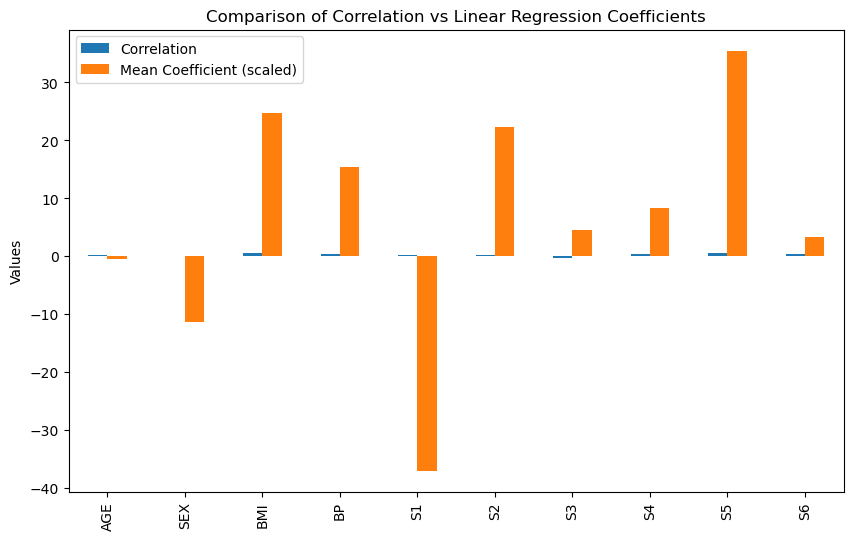

In [56]:
# Extract correlations of features with target variable Y
correlations = df.corr()['Y'].drop('Y')

# Compute mean of coefficients from cross-validation
mean_coefs = coefs.mean() 

# Create a dataframe to hold both
comparison_df = pd.DataFrame({
    'Correlation': correlations,
    'Mean Coefficient (scaled)': mean_coefs
})

# Plot the comparison
comparison_df.plot(kind='bar', figsize=(10,6))
plt.title('Comparison of Correlation vs Linear Regression Coefficients')
plt.ylabel('Values')
plt.show()


From the comparison result above, we could say that linear regression coefficients may not always align with correlation coefficients, particularly when there are interaction effects between features. 

### Exercise 2 (coeeficient variability in a simpler model)

Try fitting a linear regression model to a subset of the features. To do this, select 3-4 columns from the normalised dataframe `nX` to use when constructing the train-test split, then fit the model parameters to this new training data as before. Describe how you selected your subset of features. Did the model coefficients for your chosen features turn out to be similar or different to those in the full model given in pre-studio notebook? (Comment on change in variability of the coefficients. If there is a difference, explain why.)

### Solution:

Firstly, we do analysis of coefficients to know the variability of each independent variables.

As the X values are normalised, this suggest that these values have same std dv, thus we can directly compare the coefficient importance of the features.

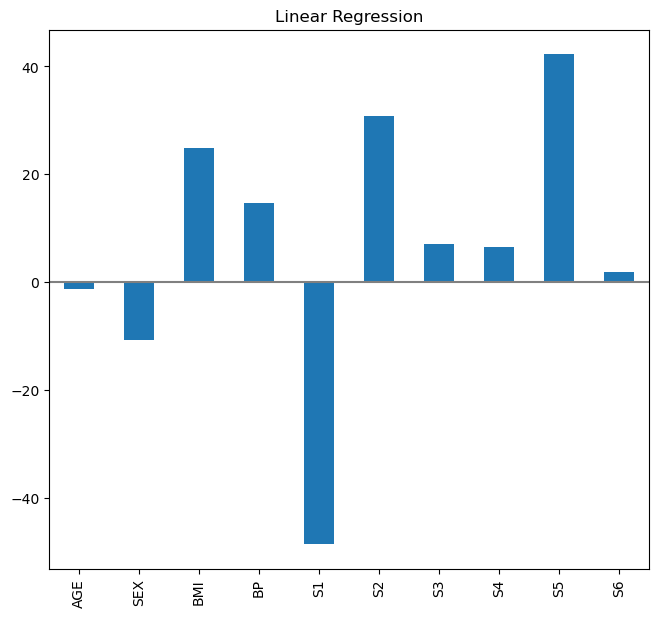

In [57]:
feature_names = nX.columns.tolist() # write the column names to a list

# create a Series for which the rows are the feature names and the data is 
# the regression coefficient values
coefs = pd.DataFrame(
    linear.coef_ * X_train.std(axis=0),
    columns=['Coefficient importance'], index=feature_names
)
coefficients.plot(kind='bar', figsize=(10, 7)) # plot these as a bar plot
plt.title('Linear Regression') # add a title
plt.axhline(y=0, color='.5') # add the reference line y = 0
plt.subplots_adjust(left=.3) # move to the left a little bit

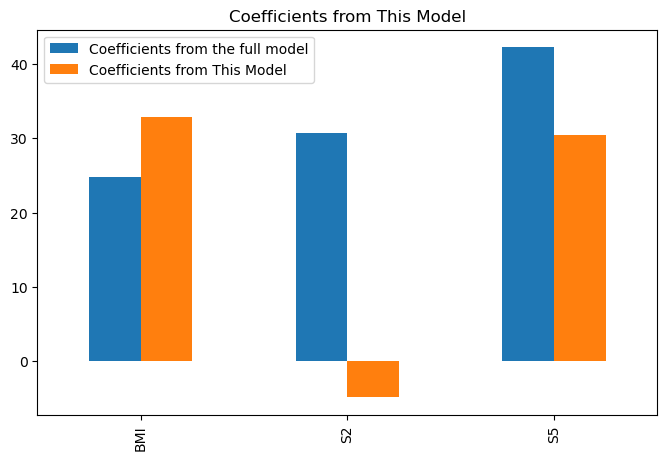

In [59]:
# Select 3-4 most correlated features
selected_features = ['BMI', 'S2', 'S5']  # Thus here we take these 3 values.
X_subset = nX[selected_features]

# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=31287)

# Fit the linear regression model
linear.fit(X_train, Y_train)

# Cross-validation to compute coefficients
subset_scores = cross_validate(
    linear, X_subset, Y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=np.random.RandomState(2351786)),
    return_estimator=True
)

# Extract and compare coefficients
subset_coefs = pd.DataFrame([est.coef_ for est in subset_scores['estimator']], columns=X_subset.columns)
mean_subset_coefs = subset_coefs.mean()

# Plot comparison
comparison_df = pd.DataFrame({
    'Coefficients from the full model': normed_coefficients[["BMI", "S2", "S5"]],
    'Coefficients from This Model': mean_subset_coefs
})

comparison_df.plot(kind='bar', title='Coefficients from This Model', figsize=(8,5))
plt.show()


It appeared to have much changes in the coefficients, that may be due to multicollinearity between variables.

***
In W8 pre-studio notebook we found the optimal tuning parameters ($\alpha$) for both Ridge and Lasso regularisation via numerical experimentation. In practice however, the process of tuning and fitting a linear regression with Ridge or Lasso regularisation is automated through the functions `RidgeCV` and `LassoCV` respectively. When we call the .fit method for `RidgeCV`, cross-valiadation is implemented by performing Ridge linear regression over a variety of tuning parameters in order to determine the optimal tuning parameter $\alpha$. Once the optimal tuning parameter is found, the model can then be fit. In fact, we can extract the optimal tuning parameter $\alpha$ by calling .alpha_. A similar process is utilised for `LassoCV`.

N.B. Both Ridge and Lasso regularisation require the feature set to be normalised. 

### Exercise 3 (RidgeCV)

Here you will use `RidgeCV` from scikit-learn to perform Ridge linear regression and cross validation all in one go. Your tasks are the following:

1. Instantiate the RidgeCV model by calling RidgeCV (done for you).
2. Fit the model to the training data.
3. Determine the training and testing R2 scores.
4. Call .alpha_ in order to determine the optimal tuning parameter alpha.

The syntax here is essentially the same as any other machine learning algorithm from scikit-learn. If you have any issues, you can consult the scikit-learn guide on `RidgeCV`.

Do you get the same optimal tuning parameter alpha as obtained in this notebook? Any idea why that is or isn't the case?

In [61]:
from sklearn.linear_model import RidgeCV

# create an array of 21 alpha values logarithmically distributed between 10**(-2) and 10**2
alfas = np.logspace(-2, 2, num=21) 

X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y,
    test_size=0.2,
    random_state=1235
) 

ridgecv = RidgeCV(alfas, store_cv_values=True)

# Now you will need to fit the model on the train data using the instantiated model ridgecv, determine the training
# and testing R^2 scores, then call .alpha_ to find the optimal tuning parameter.

### Solution:

In [68]:
# Fit the model on the training data
ridgecv.fit(X_train, Y_train)

# Predict on the training and testing data
Y_train_pred = ridgecv.predict(X_train)
Y_test_pred = ridgecv.predict(X_test)

# Compute R² scores
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)

# Get the optimal alpha
optimal_alpha = ridgecv.alpha_

print("Train R²: {:.4f}".format(train_r2))
print("Test R²: {:.4f}".format(test_r2))
print("Opt alpha: {:.4f}".format(optimal_alpha))

Train R²: 0.5311
Test R²: 0.4521
Opt alpha: 1.5849


In the pre-studio notebook, the result is:

Optimal alpha is 100.000

Training score with optimal alpha is 0.514

Testing score with optimal alpha is 0.467

Difference in result may be due to the difference between features selected, that the subset model is unable to captual all variations as in full model.

### Exercise 4 (LassoCV)

Here you will use `LassoCV` from scikit-learn to perform Lasso linear regression and cross validation all in one go. Your tasks are the following:

1. Instantiate the LassoCV model by calling LassoCV (done for you).
2. Fit the model to the training data.
3. Determine the training and testing R2 scores.
4. Call .alpha_ in order to determine the optimal tuning parameter alpha.

The syntax here is essentially the same as any other machine learning algorithm from scikit-learn. If you have any issues, you can consult the scikit-learn guide on `LassoCV`.

Do you get the same optimal tuning parameter alpha as obtained in this notebook? Any idea why that is or isn't the case?

In [69]:
from sklearn.linear_model import LassoCV

# create an array of 21 alpha values logarithmically distributed between 10**(-2) and 10**2
alfas = np.logspace(-2, 2, num=21) 

X_train, X_test, Y_train, Y_test = train_test_split(
    nX, Y,
    test_size = 0.2,
    random_state = 1235
) 

lassocv = LassoCV(alphas = alfas)

# Now you will need to fit the model on the train data using the instantiated model lassocv, determine the training
# and testing R^2 scores, then call .alpha_ to find the optimal tuning parameter.

In [70]:
# Fit the model on the training data
lassocv.fit(X_train, Y_train)

# Predict on the training and testing data
Y_train_pred = lassocv.predict(X_train)
Y_test_pred = lassocv.predict(X_test)

# Compute R² scores
train_r2 = r2_score(Y_train, Y_train_pred)
test_r2 = r2_score(Y_test, Y_test_pred)

# Get the optimal alpha
optimal_alpha = lassocv.alpha_

# Output the results
print(f"Training R^2 score: {train_r2:.4f}")
print(f"Testing R^2 score: {test_r2:.4f}")
print(f"Optimal alpha: {optimal_alpha:.4f}")

Training R^2 score: 0.5316
Testing R^2 score: 0.4507
Optimal alpha: 0.0100


In the pre-studio notebook, the result is:

Optimal alpha is 3.981

Training score with optimal alpha is 0.506

Testing score with optimal alpha is 0.473

Similarly, the reason could be due to the difference between features selected, that the subset model is unable to captual all variations as in full model.